In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import os

# データフレーム読み込み
train_df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")

# データ結合
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [2]:
# print("【訓練データ形状】：",train_df.shape)
# print("【評価データ形状】：",test_df.shape)
# print("【訓練データ】\n")
# print(train_df.info())
# print("【評価データ】\n")
# print(test_df.info())

【訓練データ形状】： (524164, 11)
【評価データ形状】： (174722, 10)
【訓練データ】

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB
None
【評価データ】

<class 'pandas.core.frame

In [2]:
# 数値列とカテゴリ列を取得
num_col = []
cat_col = []

train_df2 = train_df.drop(["id"],axis=1)

for col in train_df2.columns:
    if train_df[col].dtypes!="object":
        num_col.append(col)
    else:
        cat_col.append(col)

In [3]:
# 元の中央値をそのまま引くと？
# BPMをビン化する
# 後で削除
df = train_df.copy()
df = df.drop(["id","BeatsPerMinute"],axis=1)
df = df - df.median()

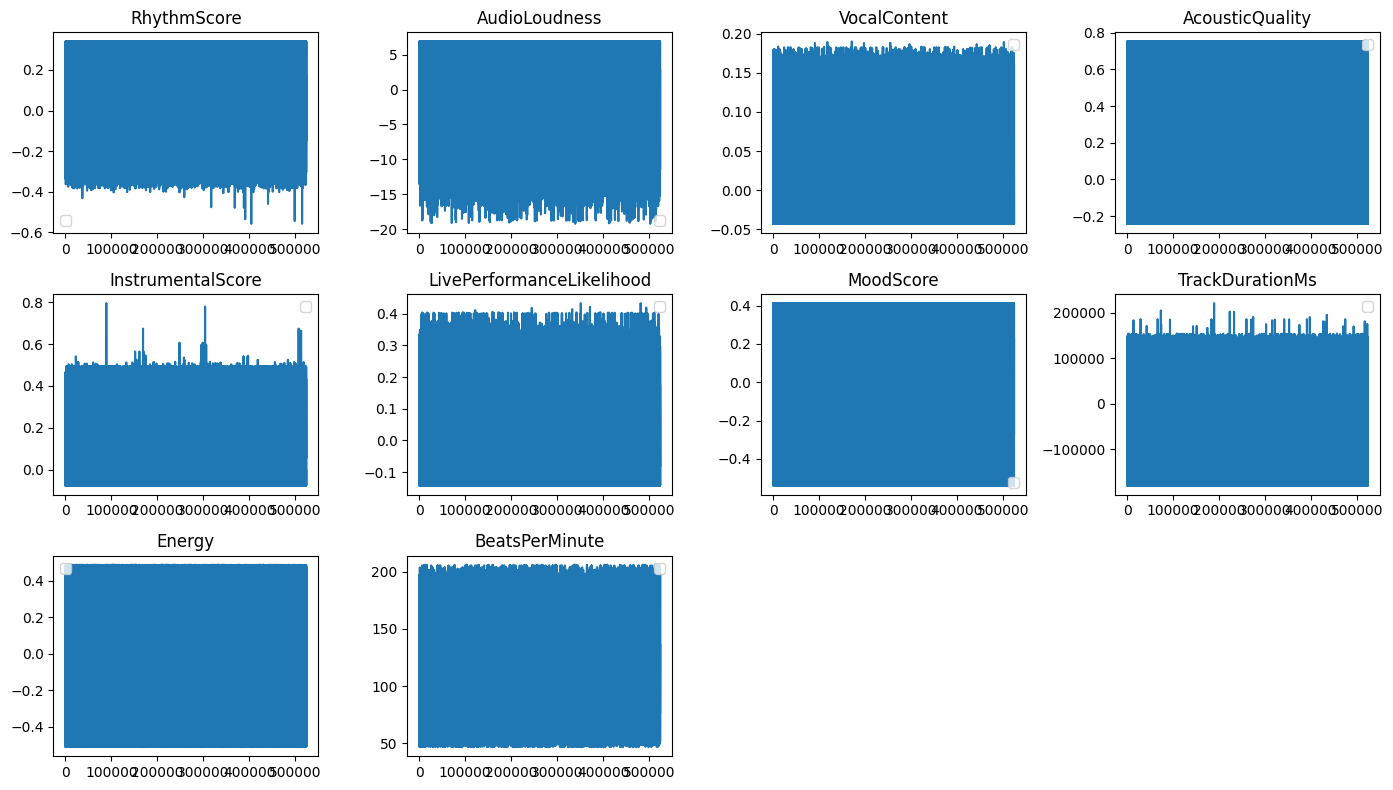

In [7]:
# 後で削除
df["BeatsPerMinute"] = train_df["BeatsPerMinute"]
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i, col in enumerate(num_col):
    plt.subplot(3, 4, i+1)
    plt.plot(df[col])
    plt.legend()
    plt.title(col)
plt.tight_layout()
plt.show()

In [5]:
# # 46%〜206%、センター = 118%
# train_df["BeatsPerMinute"].describe()

count    524164.000000
mean        119.034899
std          26.468077
min          46.718000
25%         101.070410
50%         118.747660
75%         136.686590
max         206.037000
Name: BeatsPerMinute, dtype: float64

In [90]:
# BPMをビン化する
df_bin = train_df.copy()
df_bin = df_bin.drop("id",axis=1)

def MedianMinus(df):
    feat = df.columns[:-1]
    T = "BeatsPerMinute"

    df.loc[df[T]<70,feat] = df.loc[df[T]<70,feat] \
                            - df.loc[df[T]<70,feat].median()

    df.loc[(70<df[T]) & (df[T]<=90),feat] = df.loc[(70<df[T]) & (df[T]<=90),feat] \
                            - df.loc[(70<df[T]) & (df[T]<=90),feat].median()

    df.loc[(90<df[T]) & (df[T]<=110),feat] = df.loc[(90<df[T]) & (df[T]<=110),feat] \
                            - df.loc[(90<df[T]) & (df[T]<=110),feat].median()

    df.loc[(110<df[T]) & (df[T]<=125),feat] = df.loc[(110<df[T]) & (df[T]<=125),feat] \
                            - df.loc[(110<df[T]) & (df[T]<=125),feat].median()

    df.loc[(125<df[T]) & (df[T]<=150),feat] = df.loc[(125<df[T]) & (df[T]<=150),feat] \
                            - df.loc[(125<df[T]) & (df[T]<=150),feat].median()

    df.loc[(150<df[T]) & (df[T]<=175),feat] = df.loc[(150<df[T]) & (df[T]<=175),feat] \
                            - df.loc[(150<df[T]) & (df[T]<=175),feat].median()

    df.loc[175<df[T],feat] = df.loc[175<df[T],feat] \
                            - df.loc[175<df[T],feat].median()

    df.loc[df[T]>175,T] = 6
    df.loc[df[T]>=150,T] = 5
    df.loc[df[T]>=125,T] = 4
    df.loc[df[T]>=110,T] = 3
    df.loc[df[T]>=90,T] = 2
    df.loc[df[T]>=70,T] = 1
    df.loc[(df[T]<70) & df[T]>10,T] = 0
    
    return df

df2 = MedianMinus(df_bin)

In [65]:
# 0: Very Slow 46-70 バラード系、ムード重視
# 1: Slow      71-90 ゆったり、歌モノ中心
# 2: Mid-Slow  91-110 ヒップホップ、R&B系
# 3: Medium    110-125 主流ホップ、ダンス
# 4: Mid-Fast  126-150 クラブ系、エナジー上昇
# 5: Fast      151-175 ライブ感強め、アップテンポ
# 6: Very Fast 176-206 ハード系、爆音トラック主体

# 各BPMのグラフ図示
label = ["Very Slow","Slow","Mid-Slow","Medium","Mid-Fast","Fast","Very Fast"]

# 中央値を比較してみる
median = {}
for col in num_col:
    median[col] = []
    for i in range(7):
        m = df.loc[df["BeatsPerMinute"]==i,col].median()
        median[col].append(m)

# 中央値
median_df = pd.DataFrame(median, index=[f"bin_{i}" for i in range(7)])
print(median_df)

       RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
bin_0     0.634493      -8.138076      0.065853         0.241170   
bin_1     0.633693      -8.255965      0.065765         0.241674   
bin_2     0.634056      -8.252628      0.066478         0.242944   
bin_3     0.635285      -8.251741      0.065904         0.242797   
bin_4     0.636003      -8.251190      0.066692         0.242706   
bin_5     0.636238      -8.256415      0.067123         0.242396   
bin_6     0.635062      -8.332358      0.066401         0.232815   

       InstrumentalScore  LivePerformanceLikelihood  MoodScore  \
bin_0           0.072986                   0.165793   0.564041   
bin_1           0.072607                   0.164995   0.562908   
bin_2           0.074520                   0.165437   0.563862   
bin_3           0.074525                   0.167039   0.566175   
bin_4           0.074398                   0.166744   0.566102   
bin_5           0.074778                   0.166416   0.566

In [53]:


df[med_col] = df[med_col] - df[med_col].median()

In [54]:
df

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,-0.031077,0.615557,-0.042925,-0.242497,-0.074246,-0.114941,-0.154951,47031.58685,0.314467,147.53020
1,1,0.004765,-8.015099,0.005095,0.202427,0.275167,0.004196,0.086193,-79164.54075,-0.366400,136.15963
2,2,-0.120148,-7.701076,0.044290,-0.068803,0.379567,-0.136751,-0.140952,-69188.49145,0.112867,55.31989
3,3,0.099776,6.895499,-0.013460,-0.240851,0.085470,-0.079961,-0.286072,-18116.59305,-0.024333,147.91212
4,4,-0.101718,-4.803938,-0.042925,-0.173815,-0.074246,0.165019,-0.087048,-29723.37925,0.435533,89.58511
...,...,...,...,...,...,...,...,...,...,...,...
524159,524159,0.162145,-5.153146,-0.042925,0.262237,-0.074246,0.025087,0.103262,-108155.73925,-0.507400,117.83118
524160,524160,0.340314,-3.880415,0.010955,-0.173040,0.188072,-0.041509,-0.275871,-2974.66635,-0.064733,89.02681
524161,524161,-0.091728,6.895499,0.004965,-0.073524,-0.074246,0.147585,0.022051,101174.17395,0.207000,90.75885
524162,524162,0.002506,0.841168,0.046661,-0.242497,-0.012302,0.121636,-0.195926,79026.26055,0.432467,140.63235


In [6]:
# ターゲットが 0 と 1 の分布を比較する()
import matplotlib.pyplot as plt

# 数値データの差異
def numplot(cols, df):

    # 全体の大きさ
    plt.figure(figsize=(10,8))
    
    for i, col in enumerate(cols):

        # 上下5%の値を取る
        # low,high = train_df[col].quantile([0,0.98])
        
        plt.subplot(5, 2, i+1)
        plt.hist(df[col], bins=50, 
                 density=True, rwidth=0.7)

        # plt.xlim(low,high)
        plt.title(col)
        plt.legend()

    # 揃える
    plt.tight_layout()

    # 描画する
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


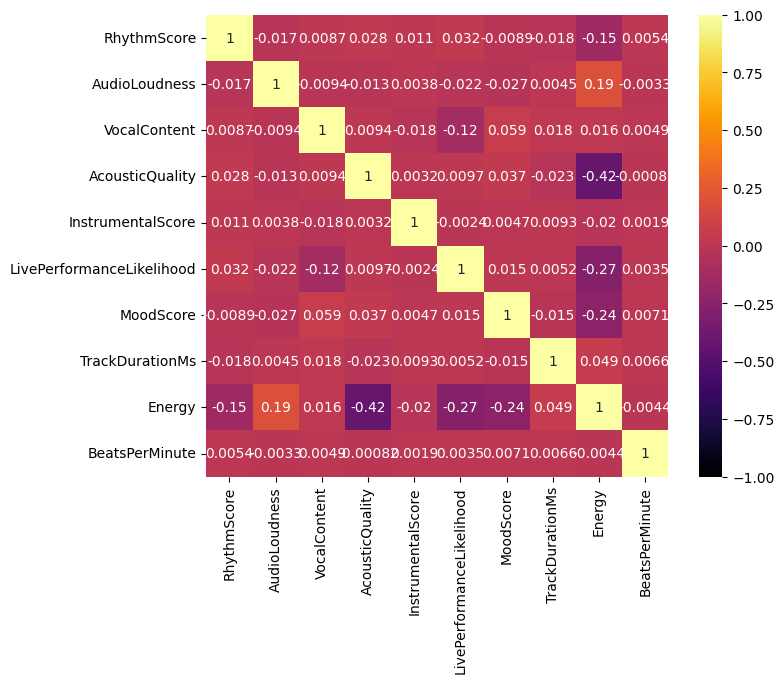

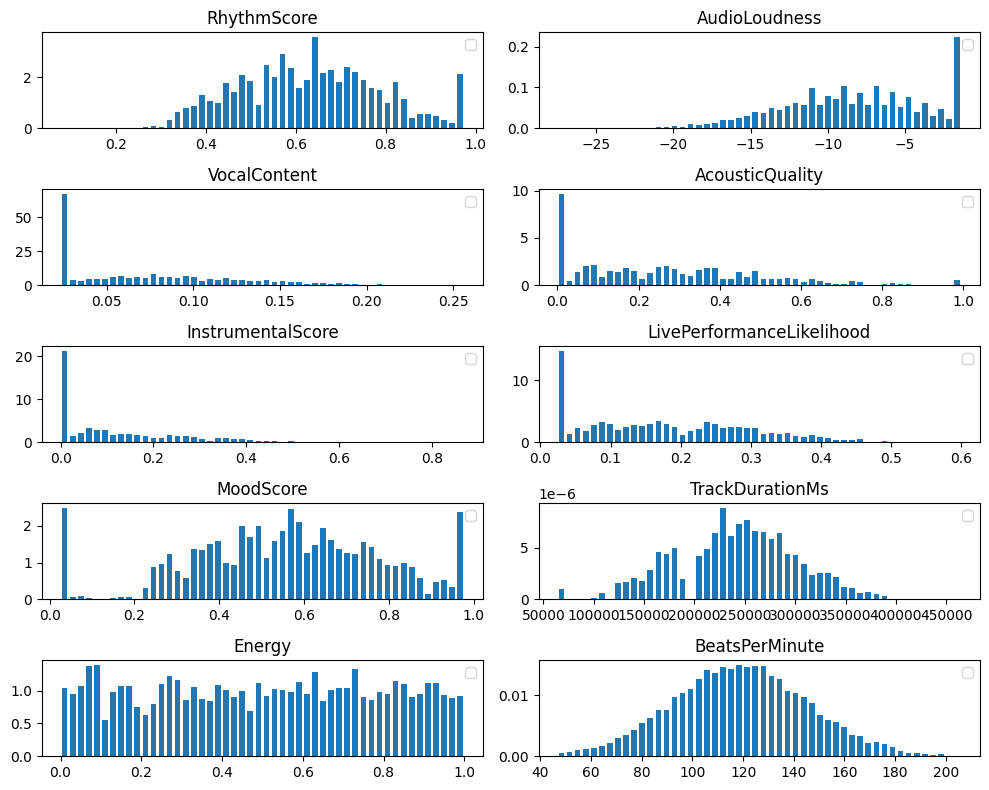

In [13]:
# 前処理前の相関分布を確認
import seaborn as sns
import matplotlib.pyplot as plt

# 相関係数の確認
df_corr = train_df.drop("id",axis=1).corr()
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(df_corr, mask=df_corr.isnull(), cmap="inferno", square=True, vmax=1, vmin=-1, center=0, annot=True)

# 各ヒストグラム
numplot(num_col, train_df)

In [8]:
# BPMをビン化する
df = train_df.copy()

def bpm_to_bin(df):
    col = "BeatsPerMinute"
    df.loc[df[col]<70,col] = 0
    df.loc[(70<df[col])&(df[col]<90),col] = 1
    df.loc[(90<df[col])&(df[col]<110),col] = 2
    df.loc[(110<df[col])&(df[col]<125),col] = 3
    df.loc[(125<df[col])&(df[col]<150),col] = 4
    df.loc[(150<df[col])&(df[col]<175),col] = 5
    df.loc[175<df[col],col] = 6
    return df

df = bpm_to_bin(train_df)

In [ ]:
# 0: Very Slow 46-70 バラード系、ムード重視
# 1: Slow      71-90 ゆったり、歌モノ中心
# 2: Mid-Slow  91-110 ヒップホップ、R&B系
# 3: Medium    110-125 主流ホップ、ダンス
# 4: Mid-Fast  126-150 クラブ系、エナジー上昇
# 5: Fast      151-175 ライブ感強め、アップテンポ
# 6: Very Fast 176-206 ハード系、爆音トラック主体

# 各BPMのグラフ図示
label = ["Very Slow","Slow","Mid-Slow","Medium","Mid-Fast","Fast","Very Fast"]

# 中央値を比較してみる
median = {}
for col in num_col:
    median[col] = []
    for i in range(7):
        m = df.loc[df["BeatsPerMinute"]==i,col].median()
        median[col].append(m)

# 中央値
median_df = pd.DataFrame(median, index=[f"bin_{i}" for i in range(7)])
print(median_df)

In [ ]:
def bpmplot(col, df):
    plt.figure(figsize=(14,4))
    for i in range(7):
        plt.subplot(2, 4, i+1)
        plt.hist(df.loc[df["BeatsPerMinute"]==i,col], bins=50, 
                    density=True, rwidth=0.7)
        plt.title(f"[{label[i]}] {col}")
        plt.legend()
    plt.tight_layout()
    plt.show()

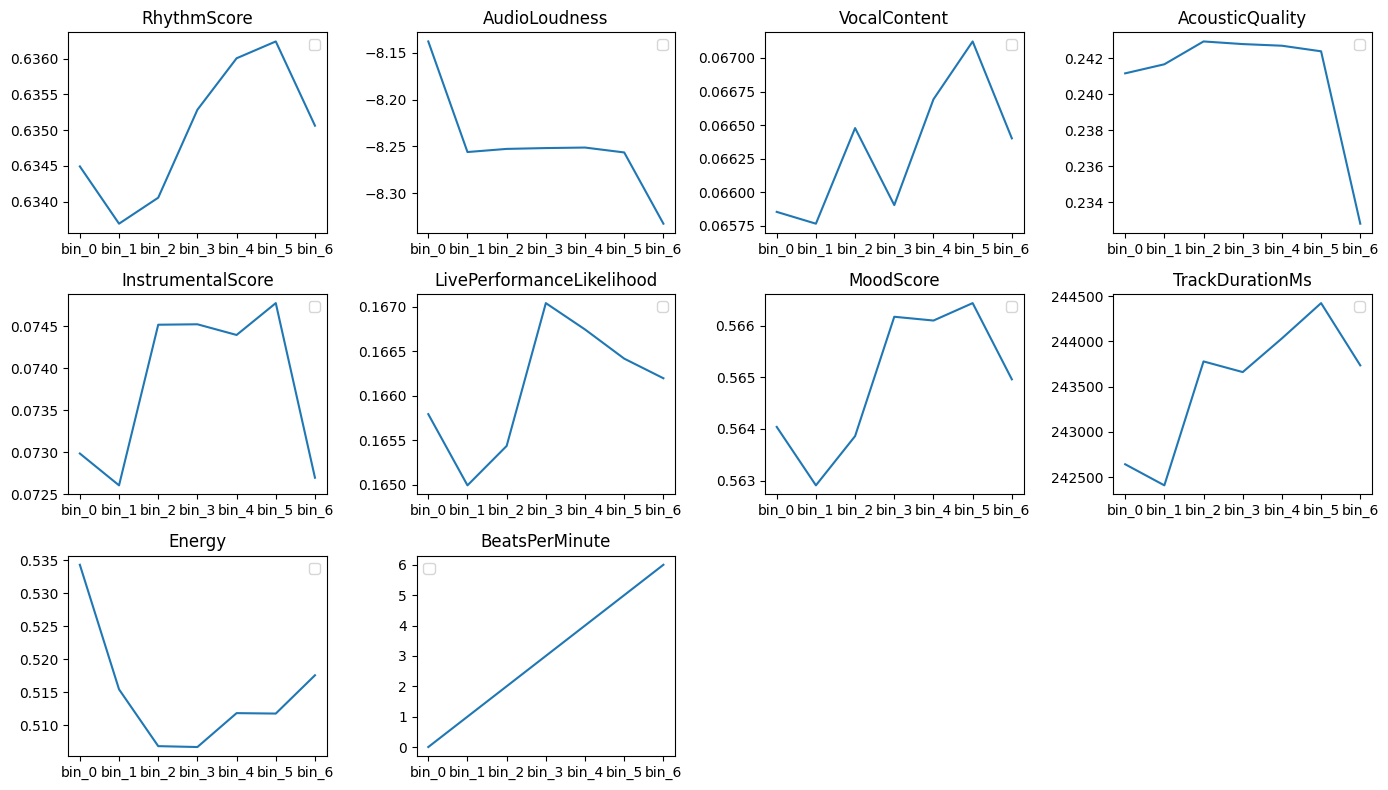

In [25]:
plt.figure(figsize=(14,8))
for i, col in enumerate(num_col):
    plt.subplot(3, 4, i+1)
    plt.plot(median_df[col])
    plt.legend()
    plt.title(col)
plt.tight_layout()
plt.show()

In [13]:
def medcheck(col,df):
    plt.figure(figsize=(14,4))
    for i in range(7):
        plt.subplot(5,2,i+1)
        plt.plot(median_df["RhythmScore"].values,label=i)
        plt.title(f"[{label[i]}] {col}")
        plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def bpmplot(col, df):
    plt.figure(figsize=(14,4))
    for i in range(7):
        plt.subplot(2, 4, i+1)
        plt.hist(df.loc[df["BeatsPerMinute"]==i,col], bins=50, 
                    density=True, rwidth=0.7)
        plt.title(f"[{label[i]}] {col}")
        plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# 0: Very Slow 46-70 バラード系、ムード重視
# 1: Slow      71-90 ゆったり、歌モノ中心
# 2: Mid-Slow  91-110 ヒップホップ、R&B系
# 3: Medium    110-125 主流ホップ、ダンス
# 4: Mid-Fast  126-150 クラブ系、エナジー上昇
# 5: Fast      151-175 ライブ感強め、アップテンポ
# 6: Very Fast 176-206 ハード系、爆音トラック主体

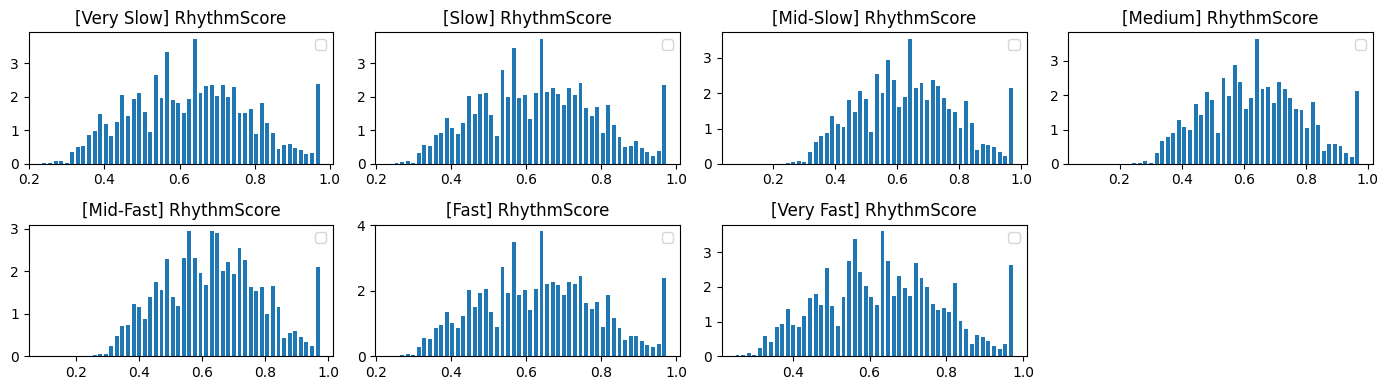

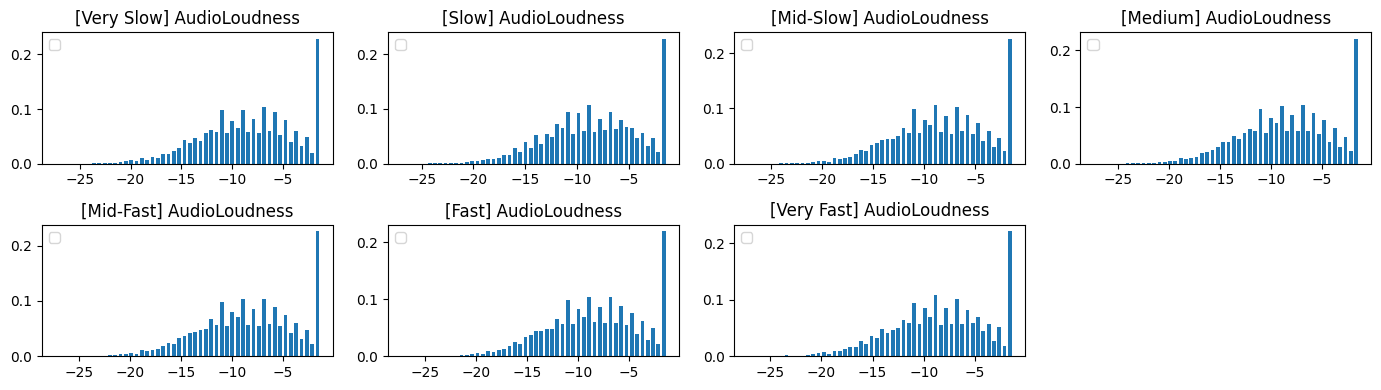

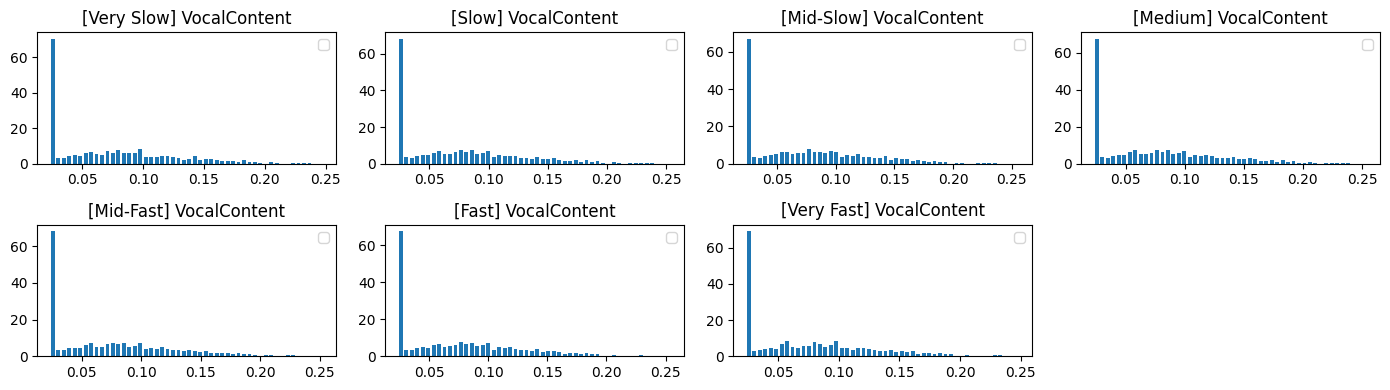

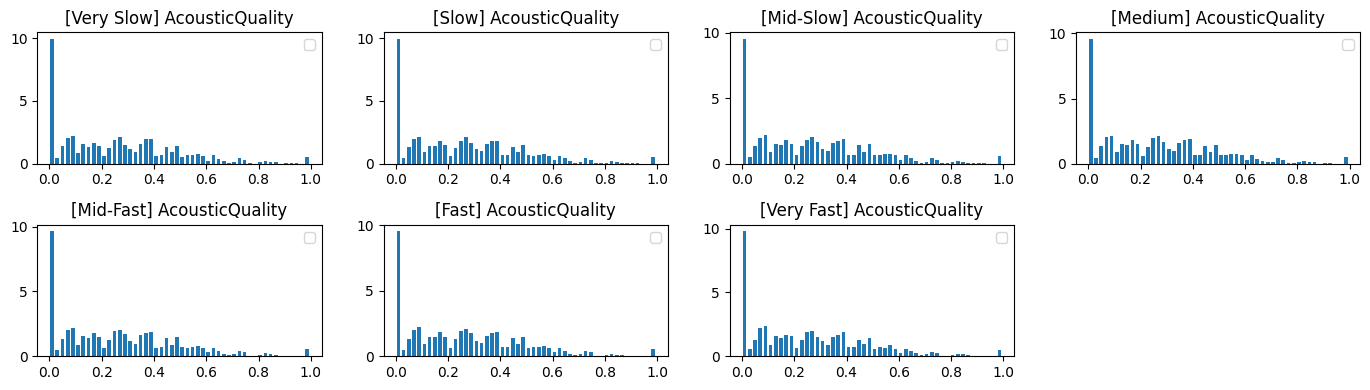

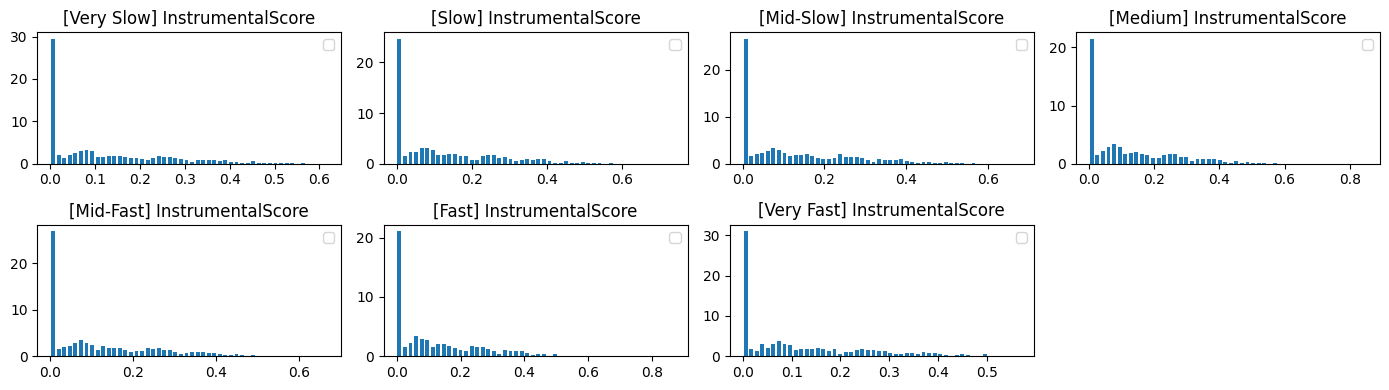

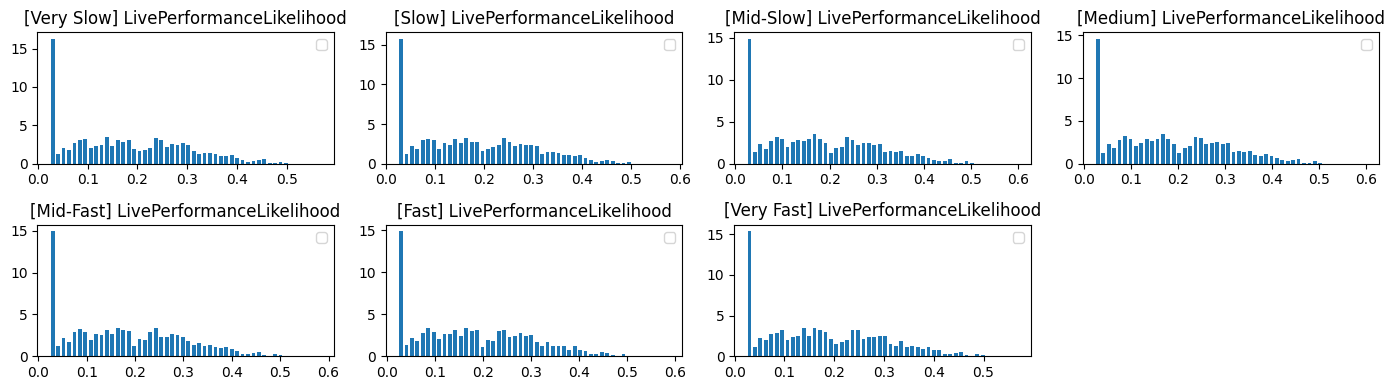

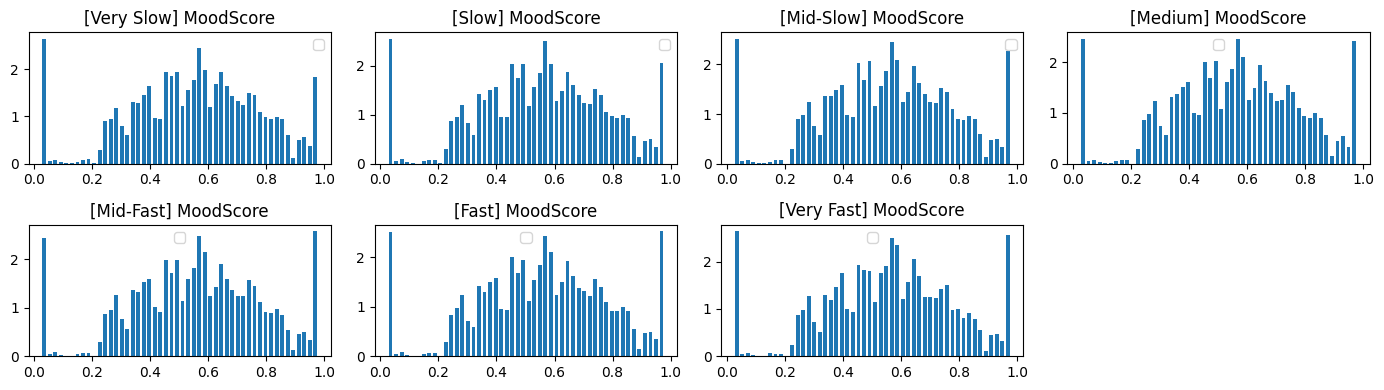

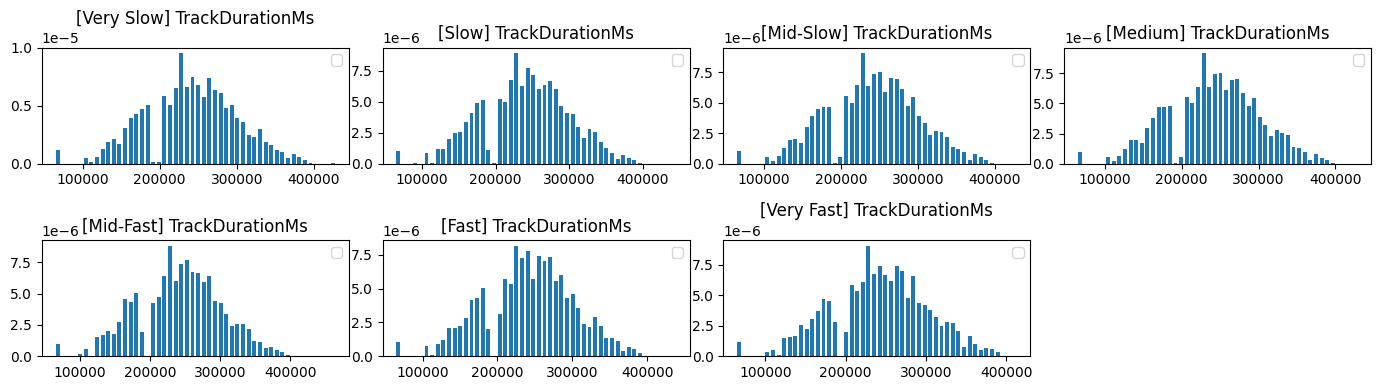

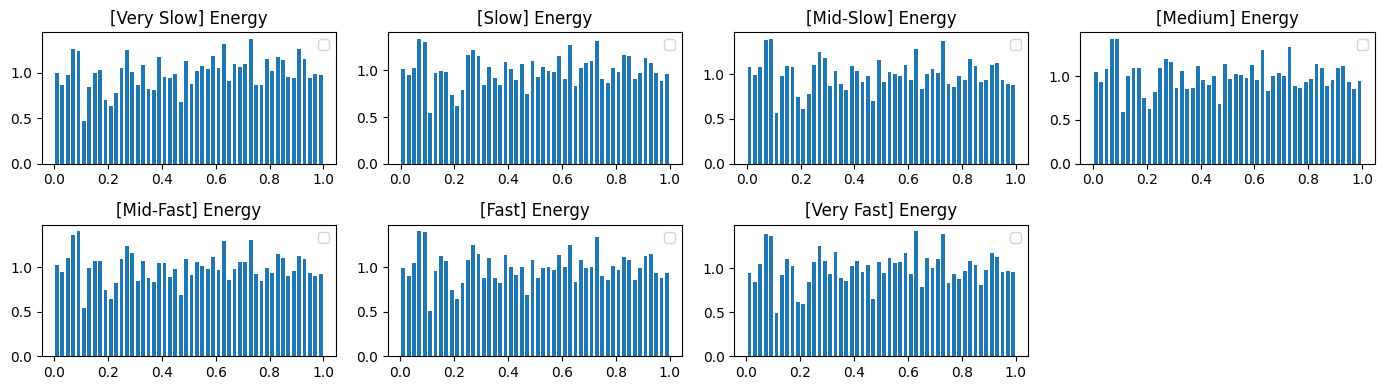

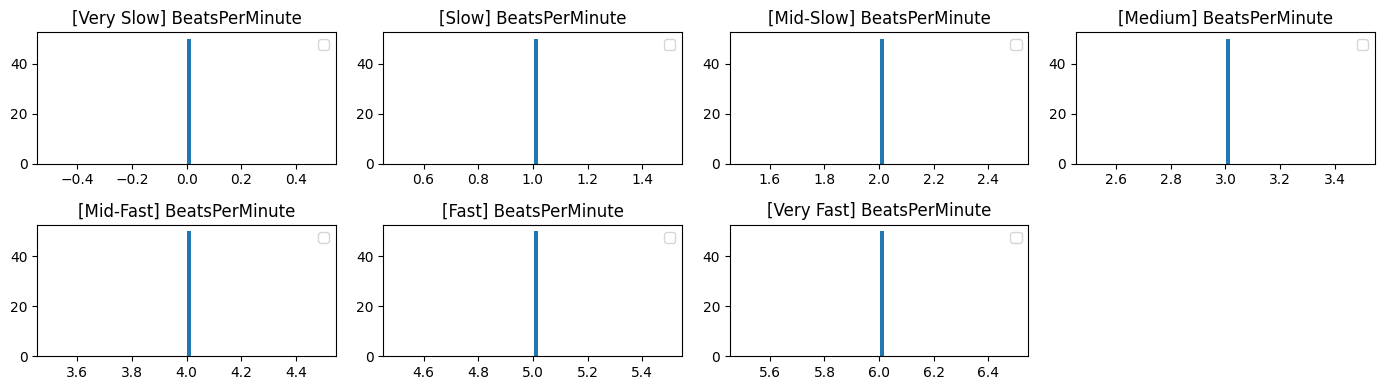

In [123]:
# 各ビートの特徴量を図示
for col in num_col:
    bpmplot(col, df)

【Slow(71-90)】


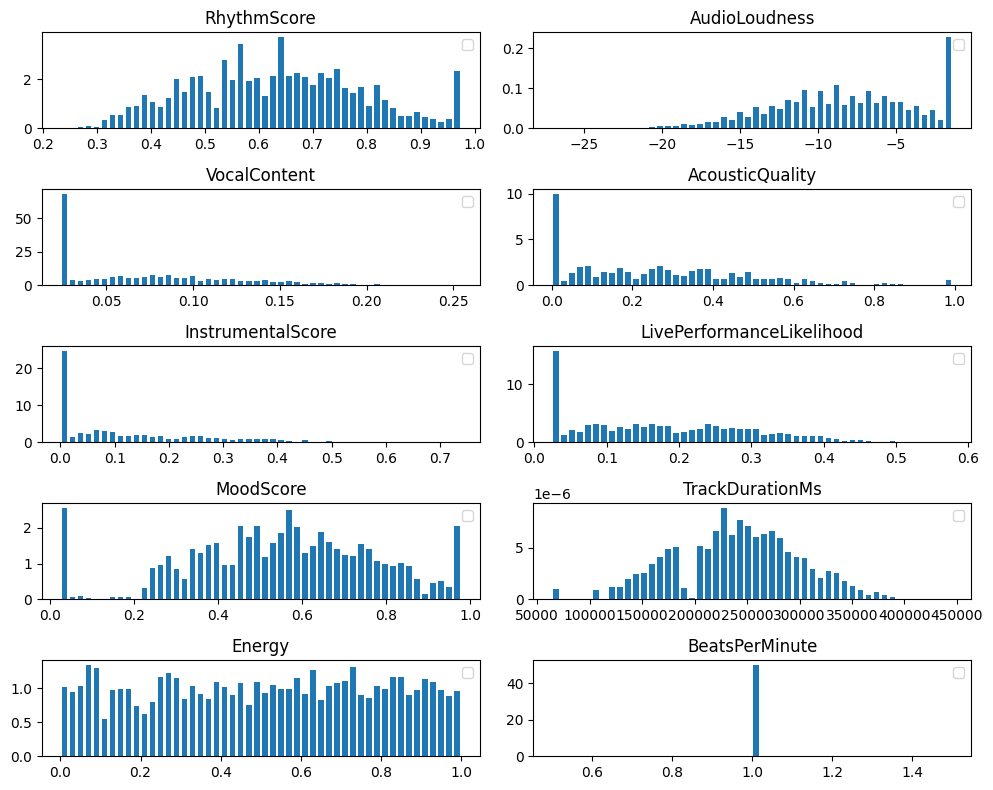

In [26]:
print("【Slow(71-90)】")
numplot(num_col, df[df["BeatsPerMinute"]==1])

【Mid-SLow(91-110)】


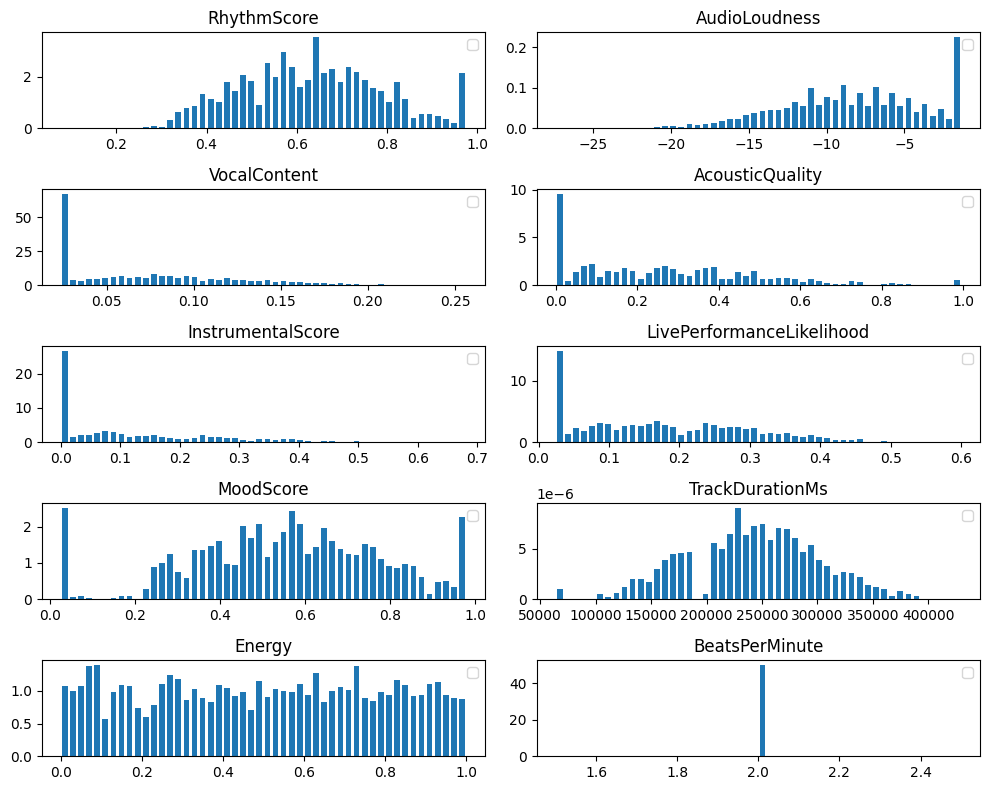

In [27]:
print("【Mid-SLow(91-110)】")
numplot(num_col, df[df["BeatsPerMinute"]==2])

In [ ]:
# # 訓練データとテストデータに分離
# # train = all_df[:len(train_df)]
# # test = all_df[len(train_df):]

# # 訓練データをx,yに分割
# X_train = train_df.drop(["id","BeatsPerMinute"],axis=1)
# y_train = train_df["BeatsPerMinute"]
# X_test = test_df.drop("id",axis=1)

In [ ]:
# # ラベルエンコード
# from sklearn.preprocessing import LabelEncoder

# LE = LabelEncoder()

# for col in X_train.columns:
#     if col in cat_col:
        
#         # 訓練データでfit
#         LE.fit(X_train[col])

#         # 訓練・テストデータをそれぞれtransform
#         X_train[col] = LE.transform(X_train[col])
#         X_test[col] = LE.transform(X_test[col])

# # データフレーム変換
# X_train_df = pd.DataFrame(X_train,columns=cat_col)
# X_test_df = pd.DataFrame(X_test,columns=cat_col)

### 【Light GBM】

In [ ]:
# ###################################################
# ############ Light GBM ############################
# ###################################################
# import lightgbm as lgb
# from sklearn.model_selection import KFold

# # 学習、バリデーションデータ
# pred_lgb = np.zeros(len(train_df))
# pred_lgb_test = np.zeros(len(test_df))
# models_lgb = []

# # 入力データ
# X = X_train
# y = y_train

# # 評価履歴を格納する辞書
# evals_result_lgb = {}

# # パラメータ
# lgbm_params = {
#     'objective': 'regression',
#     "device": "cpu",
#     # "device": "gpu",
#     'metric': 'rmse',
#     'verbose': -1,              # ログ出力の制御
#     'boosting_type': 'gbdt',
#     # 'learning_rate': 0.01,
#     # 'feature_fraction': 0.6956717916553479,
#     # 'num_leaves':       153,
#     # 'bagging_fraction': 0.5279852787927486,
#     # 'bagging_freq':     4,
#     # 'lambda_l1':        0.004603414256652151,
#     # 'lambda_l2':        0.013858762846118894,
#     # 'min_data_in_leaf': 87,
#     }

# # クロスバリデーション
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold,(train_idx,valid_idx) in enumerate(kf.split(X)):

#     print("#"*25)
#     print(f"### Folf {fold+1}")
#     print("#"*25)
    
#     X_train_kf = X.iloc[train_idx,:]
#     y_train_kf = y.iloc[train_idx]
#     X_valid_kf = X.iloc[valid_idx,:]
#     y_valid_kf = y.iloc[valid_idx]
    
#     # データセット作成
#     lgb_train_lgb = lgb.Dataset(X_train_kf,y_train_kf)
#     lgb_valid_lgb = lgb.Dataset(X_valid_kf,y_valid_kf)


#     # 学習
#     model_lgb = lgb.train(
#         lgbm_params,
#         lgb_train_lgb,
#         num_boost_round=2000,
#         valid_sets=[lgb_train_lgb,lgb_valid_lgb],
#         valid_names=["train","valid"],
#         callbacks=[
#             lgb.early_stopping(stopping_rounds=100,verbose=False),
#             lgb.record_evaluation(evals_result_lgb),
#             lgb.log_evaluation(100),])

#     # 各foldでのバリデーション予測
#     pred_lgb[valid_idx] = model_lgb.predict(
#         X_valid_kf, num_iteration=model_lgb.best_iteration)
    
#     # モデルの追加
#     models_lgb.append(model_lgb)

#     # テストの予測
#     pred_lgb_test = pred_lgb_test + model_lgb.predict(
#         X_test, num_iteration=model_lgb.best_iteration)

# # FOLD数で割る
# pred_lgb_test = pred_lgb_test/5

In [ ]:
# # 訓練データのスコア
# # from sklearn.metrics import f1_score
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# RMSE_lgb = np.sqrt(mean_squared_error(y,pred_lgb))
# print(f"LGB: RMSE score = {RMSE_lgb}")

# # 学習曲線
# lgb.plot_metric(evals_result_lgb,title="LightGBM RMSE",)

In [ ]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

# sample_submission['y'] = pred_lgb_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

### 【XGBoost】

In [ ]:
# #################################################
# ############ XGBoost ############################
# #################################################
# import xgboost as xgb
# from sklearn.model_selection import KFold
# from sklearn.model_selection import StratifiedKFold

# # 学習、バリデーションデータ
# pred_xgb = np.zeros(len(train_df))
# pred_xgb_test = np.zeros(len(test_df))
# models_xgb = []

# # 入力データ
# X = X_train
# y = y_train

# # 評価履歴を保存する辞書
# evals_result_xgb = {}

# # パラメータ
# xgb_params = {
#     "objective": "reg:squarederror",
#     # "tree_method": "hist",
#     # "tree_method": "gpu_hist",
#     # "gpu_id": 0,
#     "eval_metric": "rmse",
# }

# # クロスバリデーション
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold, (train_idx,valid_idx) in enumerate(kf.split(X)):

#     print("#"*25)
#     print(f"### Fold {fold+1}")
#     print("#"*25)

#     # foldごとの訓練、バリデーションデータ
#     X_train_kf = X.iloc[train_idx,:]
#     y_train_kf = y.iloc[train_idx]
#     X_valid_kf = X.iloc[valid_idx,:]
#     y_valid_kf = y.iloc[valid_idx]

#     # DMatrixに変換
#     dtrain = xgb.DMatrix(X_train_kf,label=y_train_kf)
#     dvalid = xgb.DMatrix(X_valid_kf,label=y_valid_kf)

#     # 学習
#     model_xgb = xgb.train(
#         xgb_params,
#         dtrain,
#         num_boost_round=2000,
#         evals=[(dtrain,"train"),(dvalid,"valid")],
#         early_stopping_rounds=100,
#         evals_result=evals_result_xgb,
#         verbose_eval=100,
#     )

#     # 各foldでのバリデーション予測
#     pred_xgb[valid_idx] = model_xgb.predict(
#         dvalid,
#         iteration_range=(0,model_xgb.best_iteration+1))

#     # モデルの追加
#     models_xgb.append(model_xgb)

#     # テストの予測
#     dtest = xgb.DMatrix(X_test)
#     pred_xgb_test = pred_xgb_test + model_xgb.predict(
#         dtest,
#         iteration_range=(0,model_xgb.best_iteration+1))

# # FOLD数で割る
# pred_xgb_test = pred_xgb_test/5

In [ ]:
# # 訓練データのスコア
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# RMSE_xgb = np.sqrt(mean_squared_error(y,pred_xgb))
# print(f"LGB: RMSE score = {RMSE_xgb}")

# # 学習曲線
# lgb.plot_metric(evals_result_xgb,title="XGBoost RMSE",)

In [ ]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

# sample_submission['y'] = pred_xgb_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

### 【CatBoost】

In [ ]:
# #################################################
# ############ CatBoost ############################
# #################################################
# from catboost import Pool, train
# from sklearn.model_selection import KFold

# # 学習、バリデーションデータ
# pred_cb = np.zeros(len(train_df))
# pred_cb_test = np.zeros(len(test_df))
# models_cb = []

# # 入力データ
# X = X_train
# y = y_train

# # 履歴を保存
# cb_RMSE_valid = []

# cat_params = {
#     "loss_function": "RMSE",
#     "eval_metric": "RMSE",
#     "task_type": "CPU",
#     # "task_type": "GPU",
#     # "devices": "0",
#     "iterations": 2000,
#     "verbose": 100,
# }

# # クロスバリデーション
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold, (train_idx,valid_idx) in enumerate(kf.split(X)):

#     print("#"*25)
#     print(f"### Fold {fold+1}")
#     print("#"*25)
    
#     X_train_kf = X.iloc[train_idx,:]
#     y_train_kf = y.iloc[train_idx]
#     X_valid_kf = X.iloc[valid_idx,:]
#     y_valid_kf = y.iloc[valid_idx]    

#     # object型をカテゴリ型に変換
#     for col in cat_col:
#         X_train_kf.loc[:,col] = X_train_kf.loc[:,col].astype("category")
#         X_valid_kf.loc[:,col] = X_valid_kf.loc[:,col].astype("category")

#     # データセット設定
#     train_pool = Pool(X_train_kf,y_train_kf,cat_features=cat_col)
#     valid_pool = Pool(X_valid_kf,y_valid_kf,cat_features=cat_col)

#     # 学習
#     model_cb = train(
#         params=cat_params,
#         dtrain=train_pool,
#         eval_set=valid_pool,
#         early_stopping_rounds=100)

#     # 各foldでのバリデーション予測
#     pred_cb[valid_idx] = model_cb.predict(X_valid_kf,
#         ntree_end=model_cb.best_iteration_,)
    

#     # モデルを追加
#     models_cb.append(model_cb)

#     evals_result = model_cb.get_evals_result()
#     cb_RMSE_valid.append(evals_result["validation"]["RMSE"])

#     # テストの予測
#     pred_cb_test = pred_cb_test + model_cb.predict(X_test,
#         ntree_end=model_cb.best_iteration_,)

# # FOLD数で割る
# pred_cb_test = pred_cb_test/5

In [ ]:
# # 訓練データのスコア
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# RMSE_cb = np.sqrt(mean_squared_error(y,pred_cb))
# print(f"CATBoost: RMSE score = {RMSE_cb}")

In [ ]:
# plt.plot(evals_result["learn"]["RMSE"], label="Train " + "RMSE")
# plt.plot(evals_result["validation"]["RMSE"], label="Valid " + "RMSE")
# plt.xlabel("Iteration")
# plt.ylabel("RMSE")
# plt.title(f"CatBoost RMSE Learning Curve")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

# sample_submission['y'] = pred_cb_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

In [ ]:
# import  matplotlib.pyplot as plt
# # 履歴の可視化
# plt.plot(cb_auc_score, label='Validation')
# plt.xlabel('Iteration')
# plt.ylabel('AUC')
# plt.grid()
# plt.legend()
# plt.title("CabBoost AUC")
# plt.show()

In [ ]:
# # アンサンブル
# # バリデーションデータ
# ensemble_valid = (pred_lgb + pred_xgb + pred_cb) / 3.0
# valid_score = np.sqrt(mean_squared_error(y,ensemble_valid))
# print(f"valid score = {valid_score}")

In [ ]:
# # 提出データ
# ensemble_test = (pred_lgb_test + pred_xgb_test + pred_cb_test) / 3.0

# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

# sample_submission['BeatsPerMinute'] = ensemble_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

In [ ]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import roc_auc_score

# print("# STACKING ENSEMBLE IMPLEMENTATION")
# print("# " + "="*50)
# print("# Combining top 3 models: LightGBM, XGBoost, CatBoost")
# print("# Meta-learner: Logistic Regression")
# print("# " + "="*50)

# stacking_train = pd.DataFrame({
#     'lgb': pred_lgb,
#     'xgb': pred_xgb, 
#     'cat': pred_cb
# })

# stacking_test = pd.DataFrame({
#     'lgb': pred_lgb_test,
#     'xgb': pred_xgb_test,
#     'cat': pred_cb_test
# })

# print(f"# Stacking train shape: {stacking_train.shape}")
# print(f"# Stacking test shape: {stacking_test.shape}")

# print("\n# METHOD 1: WEIGHTED AVERAGE")
# print("# " + "-"*30)

# scores = [RMSE_lgb, RMSE_xgb, RMSE_cb]  
# total_score = sum(scores)
# weights = [score/total_score for score in scores]

# print(f"# Model weights:")
# print(f"# LightGBM: {weights[0]:.4f}")
# print(f"# XGBoost:  {weights[1]:.4f}")
# print(f"# CatBoost: {weights[2]:.4f}")

# weighted_oof = (stacking_train['lgb'] * weights[0] + 
#                 stacking_train['xgb'] * weights[1] +
#                 stacking_train['cat'] * weights[2])

# weighted_test = (stacking_test['lgb'] * weights[0] + 
#                  stacking_test['xgb'] * weights[1] + 
#                  stacking_test['cat'] * weights[2])

# weighted_score = np.sqrt(mean_squared_error(y, weighted_oof))
# print(f"# Weighted Average RMSE: {weighted_score:.6f}")

# print("\n# METHOD 2: LOGISTIC REGRESSION META-LEARNER")
# print("# " + "-"*40)

# meta_learner = LogisticRegression(random_state=42, max_iter=1000)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# cv_scores = cross_val_score(meta_learner, stacking_train, y, 
#                            cv=kf, scoring='neg_root_mean_squared_error', n_jobs=1)

# print(f"# Meta-learner CV scores: {[f'{score:.6f}' for score in cv_scores]}")
# print(f"# Meta-learner mean CV: {cv_scores.mean():.6f} ± {cv_scores.std():.6f}")

# meta_learner.fit(stacking_train, y)
# meta_oof = meta_learner.predict_proba(stacking_train)[:, 1]
# meta_test = meta_learner.predict_proba(stacking_test)[:, 1]
# meta_score = np.sqrt(mean_squared_error((y, meta_oof)))

# print(f"# Meta-learner RMSE: {meta_score:.6f}")

# coefficients = meta_learner.coef_[0]
# print(f"# Meta-learner coefficients:")
# print(f"# LightGBM: {coefficients[0]:.4f}")
# print(f"# XGBoost:  {coefficients[1]:.4f}")
# print(f"# CatBoost: {coefficients[2]:.4f}")
# print(f"# Intercept: {meta_learner.intercept_[0]:.4f}")

# print("\n# METHOD 3: SIMPLE AVERAGE (BASELINE)")
# print("# " + "-"*35)

# simple_oof = (stacking_train['lgb'] + stacking_train['xgb'] + stacking_train['cat']) / 3
# simple_test = (stacking_test['lgb'] + stacking_test['xgb'] + stacking_test['cat']) / 3
# simple_score = np.sqrt(mean_squared_error((y, simple_oof)))

# print(f"# Simple Average RMSE: {simple_score:.6f}")

# print("\n# ENSEMBLE METHODS COMPARISON")
# print("# " + "="*40)
# ensemble_results = [
# ('Individual LightGBM', RMSE_lgb),
# ('Individual XGBoost', RMSE_xgb),
# ('Individual CatBoost', RMSE_cb),
# ('Weighted Average', weighted_score),
# ('Meta-learner (LogReg)', meta_score),
# ('Simple Average', simple_score)
# ]

# ensemble_results.sort(key=lambda x: x[1], reverse=True)

# for i, (method, score) in enumerate(ensemble_results, 1):
#     print(f"# {i}. {method:<25}: {score:.6f}")

# best_method, best_score = ensemble_results[0]
# print(f"\n# BEST ENSEMBLE METHOD: {best_method}")
# print(f"# BEST ENSEMBLE SCORE: {best_score:.6f}")

# if 'Meta-learner' in best_method:
#     final_oof = meta_oof
#     final_test = meta_test
#     print("# Using Meta-learner predictions for final submission")
# elif 'Weighted' in best_method:
#     final_oof = weighted_oof
#     final_test = weighted_test
#     print("# Using Weighted Average predictions for final submission")
# else:
#     final_oof = simple_oof
#     final_test = simple_test
#     print("# Using Simple Average predictions for final submission")

# print("\n# STACKING ENSEMBLE COMPLETED!")
# print("# " + "="*50)

### 【Neural Net】

In [ ]:
# import random
# import os
# import pandas as pd
# import numpy as np
# from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt

# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import f1_score

# # pytorch実装
# import torch # Tensorの作成や操作
# import torch.nn as nn # ニューラルネットワーク
# import torch.nn.functional as F # 関数をメソッドとして提供
# import torch.optim as optim # オプティマイザ
# from torch.utils.data import Dataset, DataLoader
# from torch.autograd import Variable

# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_auc_score
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import time

# # GPUの使用状況確認
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# # データフレーム読み込み
# train_df = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
# test_df = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")

# # 設定
# SEED = 42
# CATEGORICAL = cat_col
# NUMERICAL = num_col
# TARGET = "y"
# USE = CATEGORICAL + NUMERICAL
# df_train = train_df.drop("id",axis=1)
# df_test = test_df.drop("id",axis=1)

In [ ]:
# # 標準化 + ラベルエンコード
# def preprocessing(df_train, df_test, cat_cols=CATEGORICAL, num_cols=NUMERICAL, target=TARGET):

#     # 訓練データ + テストデータ
#     df = pd.concat([df_train.drop(columns=target), df_test])
#     y = df_train[target]
#     train_len = len(df_train)
    
#     # 欠損埋め
#     df[cat_cols] = df[cat_cols].fillna('None')
#     df[num_cols] = df[num_cols].fillna(0)

#     train = df[:train_len]
#     test = df[train_len:]

#     # 標準化
#     scaler = StandardScaler()

#     # フィッティング
#     # scaler.fit(df[num_cols])
#     scaler.fit(train[num_cols])

#     # 適用
#     train[num_cols] = scaler.transform(train[num_cols])
#     test[num_cols] = scaler.transform(test[num_cols])
#     df = pd.concat([train, test])
    
#     # ラベルエンコーダ
#     for col in df.columns:
#         if col in cat_cols:
#             df[col] = LabelEncoder().fit_transform(df[col])
#             df[col]= df[col].astype('category')
            
#     return pd.concat([df.iloc[:train_len], y], axis=1), df.iloc[train_len:]

In [ ]:
# # データセット関数
# class CustomDataset(Dataset):

#     # オブジェクト定義
#     def __init__(self, df, target, cat_cols=CATEGORICAL):
#         self.df_cat = df[cat_cols]
#         self.df_num = df.drop(cat_cols, axis=1)
#         self.X_cats = self.df_cat.values.astype(np.int64)
#         self.X_nums = self.df_num.values.astype(np.float32)
#         self.target = target.values.astype(np.int64)

#     # データセットのサイズを返す
#     def __len__(self):
#         return len(self.target)

#     # 指定したインデックスのデータとラベルを返す
#     def __getitem__(self, idx):
#         return [self.X_cats[idx], self.X_nums[idx], self.target[idx]]

In [ ]:
# # NNモデル作成
# class NN_Model(nn.Module):

#     # ネットワーク構造の定義
#     def __init__(self, embedding_sizes, n_num):
#         super().__init__()
#         self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
#         n_emb = sum(e.embedding_dim for e in self.embeddings)
#         self.n_emb, self.n_num = n_emb, n_num
#         self.lin1 = nn.Linear(self.n_emb + self.n_num, 100)
#         self.lin2 = nn.Linear(100, 70)
#         self.lin3 = nn.Linear(70, 2)
#         self.bn1 = nn.BatchNorm1d(self.n_num)
#         self.bn2 = nn.BatchNorm1d(100)
#         self.bn3 = nn.BatchNorm1d(70)
#         self.emb_drop = nn.Dropout(0.6)
#         self.drops = nn.Dropout(0.3)
 
#     # 順伝播
#     def forward(self,x_cat,x_num):
#         x = [e(x_cat[:, i]) for i, e in enumerate(self.embeddings)]
#         x = torch.cat(x, dim=1)
#         x = self.emb_drop(x)
#         x2 = self.bn1(x_num)
#         x = torch.cat([x, x2], dim=1)
#         x = F.relu(self.lin1(x))
#         x = self.drops(x)
#         x = self.bn2(x)
#         x = F.relu(self.lin2(x))
#         x = self.drops(x)
#         x = self.bn3(x)
#         x = self.lin3(x)
#         return x

In [ ]:
# # 前処理の実施
# df_train, df_test = preprocessing(df_train, df_test)

# # ラベルエンコード済みカテゴリ変数の埋め込み
# # 各カテゴリ列の変数の種類
# cat_sizes = [len(df_train[col].cat.categories) for col in CATEGORICAL]

# # (入力サイズ, 50と割る2の小さい方)でエンコード
# emb_sizes = [(size, min(50, (size+1)//2)) for size in cat_sizes]

In [ ]:
# # 記録用
# hist = {
#     'train_loss': [], 'train_auc': [],
#     'val_loss': [], 'val_auc': []
# }

# # パラメータ
# bs = 64 # バッチサイズ
# EPOCHS = 10 # エポック
# FOLDS = 5 # FOLD数
# LR=1e-3 # 学習率

# # stratified KFoldの宣言
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# fold_results = []

# test_results = []

# # SKFによるデータ分割
# for fold, (train_idx, val_idx) in enumerate(skf.split(df_train.drop(columns=TARGET), df_train[TARGET])):
    
#     print(f"\n========== Fold {fold+1} ==========")

#     # 学習データ
#     X_train = df_train.drop(columns=TARGET).iloc[train_idx] 
#     y_train = df_train[TARGET].iloc[train_idx]

#     # バリデーションデータ
#     X_val = df_train.drop(columns=TARGET).iloc[val_idx]
#     y_val = df_train[TARGET].iloc[val_idx]

#     # Datasetの作成
#     train_dataset = CustomDataset(X_train, y_train)
#     val_dataset = CustomDataset(X_val, y_val)
    
#     # DataLoaderの作成
#     train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

#     # モデル構築
#     model = NN_Model(emb_sizes, len(NUMERICAL)).to(device)

#     # 最適化設定
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#     # 損失関数
#     criterion = nn.CrossEntropyLoss()

#     hist = {"train_auc": [], "val_auc": []}

#     # 学習・予測エポックのループ
#     for epoch in range(EPOCHS):

#         # 開始時間
#         start_time = time.time()

#         # 学習モード
#         model.train()

#         # ラベル、予測値の保存場所
#         y_true_train, y_pred_train = [], []

#         # プログレスバー
#         train_iter = tqdm(train_loader, desc=f"<Train> Epoch {epoch+1}", leave=False)
        
#         for cat_data, num_data, target in train_iter:

#             # DataLoaderから取り出した、カテゴリ、数値、ターゲット
#             cat_data, num_data, target = cat_data.to(device), num_data.to(device), target.to(device)

#             # パラメータの勾配を初期化
#             optimizer.zero_grad()

#             # 予測値の算出
#             output = model(cat_data, num_data)

#             # ラベルと予測値とのロス計算
#             loss = criterion(output, target)

#             # 各パラメータの勾配を算出
#             loss.backward()

#             # パラメータ更新
#             optimizer.step()

#             # ソフトマックスの分類結果を格納
#             probs = torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy()
#             y_pred_train.extend(probs)

#             # ラベルの格納
#             y_true_train.extend(target.cpu().numpy())

#             # プログレスバーの後ろにロス値を表示
#             train_iter.set_postfix(loss=loss.item())

#         # histに残すAUCスコア
#         train_auc = roc_auc_score(y_true_train, y_pred_train)

#         # 評価モード
#         model.eval()

#         # ラベル、予測値の保存場所        
#         y_true_val, y_pred_val = [], []

#         # プログレスバー
#         val_iter = tqdm(val_loader, desc=f"<Val> Epoch {epoch+1}", leave=False)

#         # 勾配を更新しない
#         with torch.no_grad():
            
#             for cat_data, num_data, target in val_iter:
    
#                 # DataLoaderから取り出した、カテゴリ、数値、ターゲット
#                 cat_data, num_data, target = cat_data.to(device), num_data.to(device), target.to(device)

#                 # 予測値の算出
#                 output = model(cat_data, num_data)

#                 # ソフトマックスの分類結果を格納
#                 probs = torch.softmax(output, dim=1)[:, 1].cpu().numpy()
#                 y_pred_val.extend(probs)

#                 # ラベルの格納
#                 y_true_val.extend(target.cpu().numpy())

#                 # プログレスバーの後ろにロス値を表示
#                 val_iter.set_postfix(loss=criterion(output, target).item())

#         # histに残すAUCスコア        
#         val_auc = roc_auc_score(y_true_val, y_pred_val)

#         # 差分時刻
#         elapsed = time.time() - start_time

#         # 履歴追加
#         hist["train_auc"].append(train_auc)
#         hist["val_auc"].append(val_auc)

#         # 進捗
#         print(f"Epoch {epoch+1}/{EPOCHS} - TrainAUC: {train_auc:.4f} | ValAUC: {val_auc:.4f} | Time: {elapsed:.1f}s")

#     # foldごとに保存
#     torch.save(model.state_dict(), f"model_fold{fold+1}.pth")
    
#     # ヒストグラムの更新
#     fold_results.append(hist)

#     # foldごとにテストデータ計算
#     model.eval()
#     with torch.no_grad():
#         X_test_cat = torch.from_numpy(df_test[CATEGORICAL].values.astype(np.int64)).to(device)
#         X_test_num = torch.from_numpy(df_test[NUMERICAL].values.astype(np.float32)).to(device)

#         # 予測
#         preds = torch.softmax(model(X_test_cat, X_test_num),dim=1)[:,1].cpu().numpy()
#         # preds = torch.softmax(model(X_test_cat, X_test_num).squeeze()).cpu().numpy()
#         test_results.append(preds)
    
# # shape = (n_folds, n_test_samples) → 平均化
# test_results = np.mean(test_results, axis=0)        

In [ ]:
# len(test_results)

In [ ]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

# sample_submission['y'] = test_results
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

In [ ]:
# # ======================
# # FoldごとのAUCをプロット
# # ======================
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,5))
# for i, hist in enumerate(fold_results):
#     plt.plot(hist["val_auc"], label=f"Fold {i+1} Val AUC")
# plt.xlabel("Epoch")
# plt.ylabel("AUC")
# plt.legend()
# plt.title("Validation AUC per Fold")
# plt.show() 

In [ ]:
# # 提出データ作成
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

# sample_submission['y'] = pred_lgb_test
# sample_submission.to_csv('submission.csv', index=False)
# print('Submission file saved.')

In [ ]:
# # 検証データの誤差の可視化
# train_loss = hist['train_loss']
# val_loss = hist['val_loss']

# fig = plt.figure()
# plt.rc('font', family='serif')
# plt.plot(range(len(train_loss)), train_loss, linewidth=1, label='train_loss')
# plt.plot(range(len(val_loss)), val_loss, color='red', linewidth=1, label='val_loss')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

In [ ]:
# print(f'validation data best acc : {best_acc}')

# # 検証データの精度の可視化
# train_acc = hist['train_accuracy']
# val_acc = hist['val_accuracy']

# fig = plt.figure()
# plt.rc('font', family='serif')
# plt.plot(range(len(train_acc)), train_acc, linewidth=1, label='train_acc')
# plt.plot(range(len(val_acc)), val_acc, color='red', linewidth=1, label='val_acc')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()

In [ ]:
# # 記録用
# hist = {
#     'train_loss': [], 'train_auc': [],
#     'val_loss': [], 'val_auc': []
# }

# # パラメータ
# bs = 64 # バッチサイズ
# EPOCHS = 5 # エポック
# FOLDS = 5 # FOLD数
# LR=1e-3 # 学習率

# # stratified KFoldの宣言
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# fold_results = []

# for fold, (train_idx, val_idx) in enumerate(skf.split(df_train.drop(columns=TARGET), df_train[TARGET])):
    
#     print(f"\n========== Fold {fold+1} ==========")

#     # データ分割
#     X_train, X_val = df_train.drop(columns=TARGET).iloc[train_idx], df_train.drop(columns=TARGET).iloc[val_idx]
#     y_train, y_val = df_train[TARGET].iloc[train_idx], df_train[TARGET].iloc[val_idx]

#     # Dataset / DataLoader
#     train_dataset = CustomDataset(X_train, y_train)
#     val_dataset = CustomDataset(X_val, y_val)
#     train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

#     # モデル・最適化・損失
#     model = NN_Model(emb_sizes, len(NUMERICAL)).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     criterion = nn.CrossEntropyLoss()

#     hist = {"train_auc": [], "val_auc": []}

#     for epoch in range(EPOCHS):
#         start_time = time.time()

#         # ===== 学習 =====
#         model.train()
#         y_true_train, y_pred_train = [], []
#         train_iter = tqdm(train_loader, desc=f"<Train> Epoch {epoch+1}", leave=False)
#         for cat_data, num_data, target in train_iter:
#             cat_data, num_data, target = cat_data.to(device), num_data.to(device), target.to(device)

#             optimizer.zero_grad()
#             output = model(cat_data, num_data)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()

#             probs = torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy()
#             y_pred_train.extend(probs)
#             y_true_train.extend(target.cpu().numpy())
#             train_iter.set_postfix(loss=loss.item())

#         train_auc = roc_auc_score(y_true_train, y_pred_train)

#         # ===== 検証 =====
#         model.eval()
#         y_true_val, y_pred_val = [], []
#         val_iter = tqdm(val_loader, desc=f"<Val> Epoch {epoch+1}", leave=False)
#         with torch.no_grad():
#             for cat_data, num_data, target in val_iter:
#                 cat_data, num_data, target = cat_data.to(device), num_data.to(device), target.to(device)
#                 output = model(cat_data, num_data)
#                 probs = torch.softmax(output, dim=1)[:, 1].cpu().numpy()
#                 y_pred_val.extend(probs)
#                 y_true_val.extend(target.cpu().numpy())
#                 val_iter.set_postfix(loss=criterion(output, target).item())

#         val_auc = roc_auc_score(y_true_val, y_pred_val)
#         elapsed = time.time() - start_time

#         hist["train_auc"].append(train_auc)
#         hist["val_auc"].append(val_auc)

#         print(f"Epoch {epoch+1}/{EPOCHS} - TrainAUC: {train_auc:.4f} | ValAUC: {val_auc:.4f} | Time: {elapsed:.1f}s")

#     fold_results.append(hist)

#     # テストデータ

# # ======================
# # FoldごとのAUCをプロット
# # ======================
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,5))
# for i, hist in enumerate(fold_results):
#     plt.plot(hist["val_auc"], label=f"Fold {i+1} Val AUC")
# plt.xlabel("Epoch")
# plt.ylabel("AUC")
# plt.legend()
# plt.title("Validation AUC per Fold")
# plt.show() 